In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss
import os

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')
run_stats = {}

In [2]:
# parameters
dataset_name = ""
model_name = "resnet_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM_species"
ood = ""


In [4]:
# initialize data attributes and loaders
save_name = f"assets/results/{dataset_name}/{model_name}/{ood}"
os.makedirs(os.path.dirname(save_name + "_blank.file"), exist_ok=True)
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data(shuffle_training_data=False)
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 375443 images
Dataset type val label type: species


Loaded 48562 images
Dataset type test label type: species


 - Min class count:  976
Loaded 20496 images
Dataset type test label type: species


 - Min class count:  976
Loaded 0 images


In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

 qsi4bt99


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-qsi4bt99:best, 58.48MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:3.9


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_rcn = []
    trn_emb = []
    trn_tgt = []

    val_inp = []
    val_rcn = []
    val_emb = []
    val_tgt = []

    ind_inp = []
    ind_rcn = []
    ind_emb = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_rcn = []
        ood_emb = []
        ood_tgt = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            emb, lgt, rcn = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

  0%|                                                                                                                    | 0/2934 [00:00<?, ?it/s]

  0%|                                                                                                            | 1/2934 [00:00<28:03,  1.74it/s]

  0%|▏                                                                                                           | 6/2934 [00:00<04:24, 11.06it/s]

  0%|▍                                                                                                          | 11/2934 [00:00<02:33, 19.04it/s]

  1%|▌                                                                                                          | 16/2934 [00:00<01:54, 25.54it/s]

  1%|▊                                                                                                          | 21/2934 [00:01<01:35, 30.64it/s]

  1%|▉                                                                                                          | 26/2934 [00:01<01:24, 34.51it/s]

  1%|█▏                                                                                                         | 31/2934 [00:01<01:17, 37.45it/s]

  1%|█▎                                                                                                         | 36/2934 [00:01<01:13, 39.54it/s]

  1%|█▍                                                                                                         | 41/2934 [00:01<01:10, 41.06it/s]

  2%|█▋                                                                                                         | 46/2934 [00:01<01:08, 42.21it/s]

  2%|█▊                                                                                                         | 51/2934 [00:01<01:07, 42.96it/s]

  2%|██                                                                                                         | 56/2934 [00:01<01:06, 43.50it/s]

  2%|██▏                                                                                                        | 61/2934 [00:01<01:05, 43.86it/s]

  2%|██▍                                                                                                        | 66/2934 [00:02<01:04, 44.18it/s]

  2%|██▌                                                                                                        | 71/2934 [00:02<01:04, 44.35it/s]

  3%|██▊                                                                                                        | 76/2934 [00:02<01:04, 44.47it/s]

  3%|██▉                                                                                                        | 81/2934 [00:02<01:03, 44.63it/s]

  3%|███▏                                                                                                       | 86/2934 [00:02<01:03, 44.66it/s]

  3%|███▎                                                                                                       | 91/2934 [00:02<01:03, 44.66it/s]

  3%|███▌                                                                                                       | 96/2934 [00:02<01:03, 44.69it/s]

  3%|███▋                                                                                                      | 101/2934 [00:02<01:03, 44.79it/s]

  4%|███▊                                                                                                      | 106/2934 [00:02<01:03, 44.74it/s]

  4%|████                                                                                                      | 111/2934 [00:03<01:03, 44.75it/s]

  4%|████▏                                                                                                     | 116/2934 [00:03<01:02, 44.79it/s]

  4%|████▎                                                                                                     | 121/2934 [00:03<01:02, 44.73it/s]

  4%|████▌                                                                                                     | 126/2934 [00:03<01:02, 44.75it/s]

  4%|████▋                                                                                                     | 131/2934 [00:03<01:02, 44.78it/s]

  5%|████▉                                                                                                     | 136/2934 [00:03<01:02, 44.83it/s]

  5%|█████                                                                                                     | 141/2934 [00:03<01:02, 44.80it/s]

  5%|█████▎                                                                                                    | 146/2934 [00:03<01:02, 44.79it/s]

  5%|█████▍                                                                                                    | 151/2934 [00:03<01:02, 44.83it/s]

  5%|█████▋                                                                                                    | 156/2934 [00:04<01:02, 44.79it/s]

  5%|█████▊                                                                                                    | 161/2934 [00:04<01:02, 44.72it/s]

  6%|█████▉                                                                                                    | 166/2934 [00:04<01:01, 44.71it/s]

  6%|██████▏                                                                                                   | 171/2934 [00:04<01:01, 44.79it/s]

  6%|██████▎                                                                                                   | 176/2934 [00:04<01:01, 44.78it/s]

  6%|██████▌                                                                                                   | 181/2934 [00:04<01:01, 44.77it/s]

  6%|██████▋                                                                                                   | 186/2934 [00:04<01:01, 44.83it/s]

  7%|██████▉                                                                                                   | 191/2934 [00:04<01:01, 44.83it/s]

  7%|███████                                                                                                   | 196/2934 [00:04<01:01, 44.77it/s]

  7%|███████▎                                                                                                  | 201/2934 [00:05<01:01, 44.79it/s]

  7%|███████▍                                                                                                  | 206/2934 [00:05<01:00, 44.85it/s]

  7%|███████▌                                                                                                  | 211/2934 [00:05<01:00, 44.82it/s]

  7%|███████▊                                                                                                  | 216/2934 [00:05<01:00, 44.80it/s]

  8%|███████▉                                                                                                  | 221/2934 [00:05<01:00, 44.84it/s]

  8%|████████▏                                                                                                 | 226/2934 [00:05<01:00, 44.81it/s]

  8%|████████▎                                                                                                 | 231/2934 [00:05<01:00, 44.79it/s]

  8%|████████▌                                                                                                 | 236/2934 [00:05<01:00, 44.79it/s]

  8%|████████▋                                                                                                 | 241/2934 [00:05<01:00, 44.85it/s]

  8%|████████▉                                                                                                 | 246/2934 [00:06<00:59, 44.83it/s]

  9%|█████████                                                                                                 | 251/2934 [00:06<00:59, 44.79it/s]

  9%|█████████▏                                                                                                | 256/2934 [00:06<00:59, 44.76it/s]

  9%|█████████▍                                                                                                | 261/2934 [00:06<00:59, 44.75it/s]

  9%|█████████▌                                                                                                | 266/2934 [00:06<00:59, 44.84it/s]

  9%|█████████▊                                                                                                | 271/2934 [00:06<00:59, 44.82it/s]

  9%|█████████▉                                                                                                | 276/2934 [00:06<00:59, 44.81it/s]

 10%|██████████▏                                                                                               | 281/2934 [00:06<00:59, 44.79it/s]

 10%|██████████▎                                                                                               | 286/2934 [00:06<00:59, 44.86it/s]

 10%|██████████▌                                                                                               | 291/2934 [00:07<00:58, 44.85it/s]

 10%|██████████▋                                                                                               | 296/2934 [00:07<00:58, 44.81it/s]

 10%|██████████▊                                                                                               | 301/2934 [00:07<00:58, 44.86it/s]

 10%|███████████                                                                                               | 306/2934 [00:07<00:58, 44.84it/s]

 11%|███████████▏                                                                                              | 311/2934 [00:07<00:58, 44.79it/s]

 11%|███████████▍                                                                                              | 316/2934 [00:07<00:58, 44.78it/s]

 11%|███████████▌                                                                                              | 321/2934 [00:07<00:58, 44.82it/s]

 11%|███████████▊                                                                                              | 326/2934 [00:07<00:58, 44.81it/s]

 11%|███████████▉                                                                                              | 331/2934 [00:07<00:58, 44.78it/s]

 11%|████████████▏                                                                                             | 336/2934 [00:08<00:58, 44.78it/s]

 12%|████████████▎                                                                                             | 341/2934 [00:08<00:57, 44.83it/s]

 12%|████████████▌                                                                                             | 346/2934 [00:08<00:57, 44.81it/s]

 12%|████████████▋                                                                                             | 351/2934 [00:08<00:57, 44.79it/s]

 12%|████████████▊                                                                                             | 356/2934 [00:08<00:57, 44.85it/s]

 12%|█████████████                                                                                             | 361/2934 [00:08<00:57, 44.79it/s]

 12%|█████████████▏                                                                                            | 366/2934 [00:08<00:57, 44.79it/s]

 13%|█████████████▍                                                                                            | 371/2934 [00:08<00:57, 44.79it/s]

 13%|█████████████▌                                                                                            | 376/2934 [00:08<00:57, 44.83it/s]

 13%|█████████████▊                                                                                            | 381/2934 [00:09<00:56, 44.82it/s]

 13%|█████████████▉                                                                                            | 386/2934 [00:09<00:56, 44.82it/s]

 13%|██████████████▏                                                                                           | 391/2934 [00:09<00:56, 44.82it/s]

 13%|██████████████▎                                                                                           | 396/2934 [00:09<00:56, 44.83it/s]

 14%|██████████████▍                                                                                           | 401/2934 [00:09<00:56, 44.80it/s]

 14%|██████████████▋                                                                                           | 406/2934 [00:09<00:56, 44.76it/s]

 14%|██████████████▊                                                                                           | 411/2934 [00:09<00:56, 44.78it/s]

 14%|███████████████                                                                                           | 416/2934 [00:09<00:56, 44.82it/s]

 14%|███████████████▏                                                                                          | 421/2934 [00:09<00:56, 44.78it/s]

 15%|███████████████▍                                                                                          | 426/2934 [00:10<00:56, 44.77it/s]

 15%|███████████████▌                                                                                          | 431/2934 [00:10<00:55, 44.83it/s]

 15%|███████████████▊                                                                                          | 436/2934 [00:10<00:55, 44.79it/s]

 15%|███████████████▉                                                                                          | 441/2934 [00:10<00:55, 44.69it/s]

 15%|████████████████                                                                                          | 446/2934 [00:10<00:55, 44.73it/s]

 15%|████████████████▎                                                                                         | 451/2934 [00:10<00:55, 44.77it/s]

 16%|████████████████▍                                                                                         | 456/2934 [00:10<00:55, 44.68it/s]

 16%|████████████████▋                                                                                         | 461/2934 [00:10<00:55, 44.79it/s]

 16%|████████████████▊                                                                                         | 466/2934 [00:10<00:55, 44.79it/s]

 16%|█████████████████                                                                                         | 471/2934 [00:11<00:54, 44.84it/s]

 16%|█████████████████▏                                                                                        | 476/2934 [00:11<00:54, 44.81it/s]

 16%|█████████████████▍                                                                                        | 481/2934 [00:11<00:54, 44.78it/s]

 17%|█████████████████▌                                                                                        | 486/2934 [00:11<00:54, 44.83it/s]

 17%|█████████████████▋                                                                                        | 491/2934 [00:11<00:54, 44.80it/s]

 17%|█████████████████▉                                                                                        | 496/2934 [00:11<00:54, 44.78it/s]

 17%|██████████████████                                                                                        | 501/2934 [00:11<00:54, 44.76it/s]

 17%|██████████████████▎                                                                                       | 506/2934 [00:11<00:54, 44.81it/s]

 17%|██████████████████▍                                                                                       | 511/2934 [00:11<00:54, 44.77it/s]

 18%|██████████████████▋                                                                                       | 516/2934 [00:12<00:54, 44.75it/s]

 18%|██████████████████▊                                                                                       | 521/2934 [00:12<00:53, 44.74it/s]

 18%|███████████████████                                                                                       | 526/2934 [00:12<00:53, 44.82it/s]

 18%|███████████████████▏                                                                                      | 531/2934 [00:12<00:53, 44.79it/s]

 18%|███████████████████▎                                                                                      | 536/2934 [00:12<00:53, 44.79it/s]

 18%|███████████████████▌                                                                                      | 541/2934 [00:12<00:53, 44.78it/s]

 19%|███████████████████▋                                                                                      | 546/2934 [00:12<00:53, 44.82it/s]

 19%|███████████████████▉                                                                                      | 551/2934 [00:12<00:53, 44.79it/s]

 19%|████████████████████                                                                                      | 556/2934 [00:12<00:53, 44.76it/s]

 19%|████████████████████▎                                                                                     | 561/2934 [00:13<00:52, 44.80it/s]

 19%|████████████████████▍                                                                                     | 566/2934 [00:13<00:52, 44.75it/s]

 19%|████████████████████▋                                                                                     | 571/2934 [00:13<00:52, 44.71it/s]

 20%|████████████████████▊                                                                                     | 576/2934 [00:13<00:52, 44.65it/s]

 20%|████████████████████▉                                                                                     | 581/2934 [00:13<00:52, 44.64it/s]

 20%|█████████████████████▏                                                                                    | 586/2934 [00:13<00:52, 44.69it/s]

 20%|█████████████████████▎                                                                                    | 591/2934 [00:13<00:52, 44.67it/s]

 20%|█████████████████████▌                                                                                    | 596/2934 [00:13<00:52, 44.66it/s]

 20%|█████████████████████▋                                                                                    | 601/2934 [00:13<00:52, 44.69it/s]

 21%|█████████████████████▉                                                                                    | 606/2934 [00:14<00:52, 44.65it/s]

 21%|██████████████████████                                                                                    | 611/2934 [00:14<00:52, 44.65it/s]

 21%|██████████████████████▎                                                                                   | 616/2934 [00:14<00:51, 44.64it/s]

 21%|██████████████████████▍                                                                                   | 621/2934 [00:14<00:51, 44.69it/s]

 21%|██████████████████████▌                                                                                   | 626/2934 [00:14<00:51, 44.67it/s]

 22%|██████████████████████▊                                                                                   | 631/2934 [00:14<00:51, 44.64it/s]

 22%|██████████████████████▉                                                                                   | 636/2934 [00:14<00:51, 44.68it/s]

 22%|███████████████████████▏                                                                                  | 641/2934 [00:14<00:51, 44.66it/s]

 22%|███████████████████████▎                                                                                  | 646/2934 [00:14<00:51, 44.59it/s]

 22%|███████████████████████▌                                                                                  | 651/2934 [00:15<00:51, 44.60it/s]

 22%|███████████████████████▋                                                                                  | 656/2934 [00:15<00:51, 44.54it/s]

 23%|███████████████████████▉                                                                                  | 661/2934 [00:15<00:50, 44.57it/s]

 23%|████████████████████████                                                                                  | 666/2934 [00:15<00:50, 44.58it/s]

 23%|████████████████████████▏                                                                                 | 671/2934 [00:15<00:50, 44.58it/s]

 23%|████████████████████████▍                                                                                 | 676/2934 [00:15<00:50, 44.64it/s]

 23%|████████████████████████▌                                                                                 | 681/2934 [00:15<00:50, 44.64it/s]

 23%|████████████████████████▊                                                                                 | 686/2934 [00:15<00:50, 44.63it/s]

 24%|████████████████████████▉                                                                                 | 691/2934 [00:15<00:50, 44.70it/s]

 24%|█████████████████████████▏                                                                                | 696/2934 [00:16<00:50, 44.68it/s]

 24%|█████████████████████████▎                                                                                | 701/2934 [00:16<00:50, 44.66it/s]

 24%|█████████████████████████▌                                                                                | 706/2934 [00:16<00:49, 44.63it/s]

 24%|█████████████████████████▋                                                                                | 711/2934 [00:16<00:49, 44.68it/s]

 24%|█████████████████████████▊                                                                                | 716/2934 [00:16<00:49, 44.67it/s]

 25%|██████████████████████████                                                                                | 721/2934 [00:16<00:49, 44.66it/s]

 25%|██████████████████████████▏                                                                               | 726/2934 [00:16<00:49, 44.73it/s]

 25%|██████████████████████████▍                                                                               | 731/2934 [00:16<00:49, 44.59it/s]

 25%|██████████████████████████▌                                                                               | 736/2934 [00:16<00:49, 44.65it/s]

 25%|██████████████████████████▊                                                                               | 741/2934 [00:17<00:49, 44.63it/s]

 25%|██████████████████████████▉                                                                               | 746/2934 [00:17<00:49, 44.61it/s]

 26%|███████████████████████████▏                                                                              | 751/2934 [00:17<00:48, 44.66it/s]

 26%|███████████████████████████▎                                                                              | 756/2934 [00:17<00:48, 44.65it/s]

 26%|███████████████████████████▍                                                                              | 761/2934 [00:17<00:48, 44.65it/s]

 26%|███████████████████████████▋                                                                              | 766/2934 [00:17<00:48, 44.66it/s]

 26%|███████████████████████████▊                                                                              | 771/2934 [00:17<00:48, 44.68it/s]

 26%|████████████████████████████                                                                              | 776/2934 [00:17<00:48, 44.66it/s]

 27%|████████████████████████████▏                                                                             | 781/2934 [00:18<00:48, 44.64it/s]

 27%|████████████████████████████▍                                                                             | 786/2934 [00:18<00:48, 44.69it/s]

 27%|████████████████████████████▌                                                                             | 791/2934 [00:18<00:47, 44.65it/s]

 27%|████████████████████████████▊                                                                             | 796/2934 [00:18<00:47, 44.65it/s]

 27%|████████████████████████████▉                                                                             | 801/2934 [00:18<00:47, 44.51it/s]

 27%|█████████████████████████████                                                                             | 806/2934 [00:18<00:47, 44.59it/s]

 28%|█████████████████████████████▎                                                                            | 811/2934 [00:18<00:47, 44.60it/s]

 28%|█████████████████████████████▍                                                                            | 816/2934 [00:18<00:47, 44.59it/s]

 28%|█████████████████████████████▋                                                                            | 821/2934 [00:18<00:47, 44.58it/s]

 28%|█████████████████████████████▊                                                                            | 826/2934 [00:19<00:47, 44.64it/s]

 28%|██████████████████████████████                                                                            | 831/2934 [00:19<00:47, 44.63it/s]

 28%|██████████████████████████████▏                                                                           | 836/2934 [00:19<00:46, 44.67it/s]

 29%|██████████████████████████████▍                                                                           | 841/2934 [00:19<00:46, 44.66it/s]

 29%|██████████████████████████████▌                                                                           | 846/2934 [00:19<00:46, 44.66it/s]

 29%|██████████████████████████████▋                                                                           | 851/2934 [00:19<00:46, 44.72it/s]

 29%|██████████████████████████████▉                                                                           | 856/2934 [00:19<00:46, 44.70it/s]

 29%|███████████████████████████████                                                                           | 861/2934 [00:19<00:46, 44.65it/s]

 30%|███████████████████████████████▎                                                                          | 866/2934 [00:19<00:46, 44.64it/s]

 30%|███████████████████████████████▍                                                                          | 871/2934 [00:20<00:46, 44.68it/s]

 30%|███████████████████████████████▋                                                                          | 876/2934 [00:20<00:46, 44.67it/s]

 30%|███████████████████████████████▊                                                                          | 881/2934 [00:20<00:45, 44.66it/s]

 30%|████████████████████████████████                                                                          | 886/2934 [00:20<00:45, 44.73it/s]

 30%|████████████████████████████████▏                                                                         | 891/2934 [00:20<00:45, 44.70it/s]

 31%|████████████████████████████████▎                                                                         | 896/2934 [00:20<00:45, 44.66it/s]

 31%|████████████████████████████████▌                                                                         | 901/2934 [00:20<00:45, 44.65it/s]

 31%|████████████████████████████████▋                                                                         | 906/2934 [00:20<00:45, 44.69it/s]

 31%|████████████████████████████████▉                                                                         | 911/2934 [00:20<00:45, 44.68it/s]

 31%|█████████████████████████████████                                                                         | 916/2934 [00:21<00:45, 44.67it/s]

 31%|█████████████████████████████████▎                                                                        | 921/2934 [00:21<00:45, 44.61it/s]

 32%|█████████████████████████████████▍                                                                        | 926/2934 [00:21<00:45, 44.36it/s]

 32%|█████████████████████████████████▋                                                                        | 931/2934 [00:21<00:45, 44.21it/s]

 32%|█████████████████████████████████▊                                                                        | 936/2934 [00:21<00:45, 44.10it/s]

 32%|█████████████████████████████████▉                                                                        | 941/2934 [00:21<00:45, 44.02it/s]

 32%|██████████████████████████████████▏                                                                       | 946/2934 [00:21<00:45, 43.95it/s]

 32%|██████████████████████████████████▎                                                                       | 951/2934 [00:21<00:45, 43.93it/s]

 33%|██████████████████████████████████▌                                                                       | 956/2934 [00:21<00:45, 43.90it/s]

 33%|██████████████████████████████████▋                                                                       | 961/2934 [00:22<00:44, 43.90it/s]

 33%|██████████████████████████████████▉                                                                       | 966/2934 [00:22<00:44, 43.89it/s]

 33%|███████████████████████████████████                                                                       | 971/2934 [00:22<00:44, 43.90it/s]

 33%|███████████████████████████████████▎                                                                      | 976/2934 [00:22<00:44, 43.89it/s]

 33%|███████████████████████████████████▍                                                                      | 981/2934 [00:22<00:44, 43.88it/s]

 34%|███████████████████████████████████▌                                                                      | 986/2934 [00:22<00:44, 43.89it/s]

 34%|███████████████████████████████████▊                                                                      | 991/2934 [00:22<00:44, 43.89it/s]

 34%|███████████████████████████████████▉                                                                      | 996/2934 [00:22<00:44, 43.89it/s]

 34%|███████████████████████████████████▊                                                                     | 1001/2934 [00:22<00:44, 43.88it/s]

 34%|████████████████████████████████████                                                                     | 1006/2934 [00:23<00:43, 43.88it/s]

 34%|████████████████████████████████████▏                                                                    | 1011/2934 [00:23<00:43, 43.88it/s]

 35%|████████████████████████████████████▎                                                                    | 1016/2934 [00:23<00:43, 43.74it/s]

 35%|████████████████████████████████████▌                                                                    | 1021/2934 [00:23<00:43, 43.80it/s]

 35%|████████████████████████████████████▋                                                                    | 1026/2934 [00:23<00:43, 43.82it/s]

 35%|████████████████████████████████████▉                                                                    | 1031/2934 [00:23<00:43, 43.83it/s]

 35%|█████████████████████████████████████                                                                    | 1036/2934 [00:23<00:43, 43.84it/s]

 35%|█████████████████████████████████████▎                                                                   | 1041/2934 [00:23<00:43, 43.94it/s]

 36%|█████████████████████████████████████▍                                                                   | 1046/2934 [00:23<00:43, 43.89it/s]

 36%|█████████████████████████████████████▌                                                                   | 1051/2934 [00:24<00:42, 43.86it/s]

 36%|█████████████████████████████████████▊                                                                   | 1056/2934 [00:24<00:42, 43.89it/s]

 36%|█████████████████████████████████████▉                                                                   | 1061/2934 [00:24<00:42, 43.90it/s]

 36%|██████████████████████████████████████▏                                                                  | 1066/2934 [00:24<00:42, 43.90it/s]

 37%|██████████████████████████████████████▎                                                                  | 1071/2934 [00:24<00:42, 43.87it/s]

 37%|██████████████████████████████████████▌                                                                  | 1076/2934 [00:24<00:42, 43.86it/s]

 37%|██████████████████████████████████████▋                                                                  | 1081/2934 [00:24<00:42, 43.85it/s]

 37%|██████████████████████████████████████▊                                                                  | 1086/2934 [00:24<00:42, 43.85it/s]

 37%|███████████████████████████████████████                                                                  | 1091/2934 [00:25<00:42, 43.86it/s]

 37%|███████████████████████████████████████▏                                                                 | 1096/2934 [00:25<00:41, 43.87it/s]

 38%|███████████████████████████████████████▍                                                                 | 1101/2934 [00:25<00:41, 43.87it/s]

 38%|███████████████████████████████████████▌                                                                 | 1106/2934 [00:25<00:41, 43.87it/s]

 38%|███████████████████████████████████████▊                                                                 | 1111/2934 [00:25<00:41, 43.87it/s]

 38%|███████████████████████████████████████▉                                                                 | 1116/2934 [00:25<00:41, 43.87it/s]

 38%|████████████████████████████████████████                                                                 | 1121/2934 [00:25<00:41, 43.89it/s]

 38%|████████████████████████████████████████▎                                                                | 1126/2934 [00:25<00:41, 43.89it/s]

 39%|████████████████████████████████████████▍                                                                | 1131/2934 [00:25<00:41, 43.90it/s]

 39%|████████████████████████████████████████▋                                                                | 1136/2934 [00:26<00:40, 43.90it/s]

 39%|████████████████████████████████████████▊                                                                | 1141/2934 [00:26<00:40, 43.89it/s]

 39%|█████████████████████████████████████████                                                                | 1146/2934 [00:26<00:40, 44.04it/s]

 39%|█████████████████████████████████████████▏                                                               | 1151/2934 [00:26<00:39, 44.82it/s]

 39%|█████████████████████████████████████████▎                                                               | 1156/2934 [00:26<00:39, 45.38it/s]

 40%|█████████████████████████████████████████▌                                                               | 1161/2934 [00:26<00:38, 45.77it/s]

 40%|█████████████████████████████████████████▋                                                               | 1166/2934 [00:26<00:38, 46.05it/s]

 40%|█████████████████████████████████████████▉                                                               | 1171/2934 [00:26<00:38, 46.17it/s]

 40%|██████████████████████████████████████████                                                               | 1176/2934 [00:26<00:37, 46.35it/s]

 40%|██████████████████████████████████████████▎                                                              | 1181/2934 [00:27<00:37, 46.45it/s]

 40%|██████████████████████████████████████████▍                                                              | 1186/2934 [00:27<00:37, 46.52it/s]

 41%|██████████████████████████████████████████▌                                                              | 1191/2934 [00:27<00:37, 46.60it/s]

 41%|██████████████████████████████████████████▊                                                              | 1196/2934 [00:27<00:37, 46.64it/s]

 41%|██████████████████████████████████████████▉                                                              | 1201/2934 [00:27<00:37, 46.66it/s]

 41%|███████████████████████████████████████████▏                                                             | 1206/2934 [00:27<00:37, 46.68it/s]

 41%|███████████████████████████████████████████▎                                                             | 1211/2934 [00:27<00:36, 46.67it/s]

 41%|███████████████████████████████████████████▌                                                             | 1216/2934 [00:27<00:36, 46.69it/s]

 42%|███████████████████████████████████████████▋                                                             | 1221/2934 [00:27<00:36, 46.71it/s]

 42%|███████████████████████████████████████████▉                                                             | 1226/2934 [00:27<00:36, 46.72it/s]

 42%|████████████████████████████████████████████                                                             | 1231/2934 [00:28<00:36, 46.67it/s]

 42%|████████████████████████████████████████████▏                                                            | 1236/2934 [00:28<00:36, 46.68it/s]

 42%|████████████████████████████████████████████▍                                                            | 1241/2934 [00:28<00:36, 46.71it/s]

 42%|████████████████████████████████████████████▌                                                            | 1246/2934 [00:28<00:36, 46.69it/s]

 43%|████████████████████████████████████████████▊                                                            | 1251/2934 [00:28<00:36, 46.70it/s]

 43%|████████████████████████████████████████████▉                                                            | 1256/2934 [00:28<00:35, 46.71it/s]

 43%|█████████████████████████████████████████████▏                                                           | 1261/2934 [00:28<00:35, 46.73it/s]

 43%|█████████████████████████████████████████████▎                                                           | 1266/2934 [00:28<00:35, 46.73it/s]

 43%|█████████████████████████████████████████████▍                                                           | 1271/2934 [00:28<00:35, 46.75it/s]

 43%|█████████████████████████████████████████████▋                                                           | 1276/2934 [00:29<00:35, 46.73it/s]

 44%|█████████████████████████████████████████████▊                                                           | 1281/2934 [00:29<00:35, 46.74it/s]

 44%|██████████████████████████████████████████████                                                           | 1286/2934 [00:29<00:35, 46.74it/s]

 44%|██████████████████████████████████████████████▏                                                          | 1291/2934 [00:29<00:35, 46.73it/s]

 44%|██████████████████████████████████████████████▍                                                          | 1296/2934 [00:29<00:35, 46.72it/s]

 44%|██████████████████████████████████████████████▌                                                          | 1301/2934 [00:29<00:34, 46.73it/s]

 45%|██████████████████████████████████████████████▋                                                          | 1306/2934 [00:29<00:34, 46.71it/s]

 45%|██████████████████████████████████████████████▉                                                          | 1311/2934 [00:29<00:34, 46.73it/s]

 45%|███████████████████████████████████████████████                                                          | 1316/2934 [00:29<00:34, 46.67it/s]

 45%|███████████████████████████████████████████████▎                                                         | 1321/2934 [00:30<00:34, 46.69it/s]

 45%|███████████████████████████████████████████████▍                                                         | 1326/2934 [00:30<00:34, 46.72it/s]

 45%|███████████████████████████████████████████████▋                                                         | 1331/2934 [00:30<00:34, 46.72it/s]

 46%|███████████████████████████████████████████████▊                                                         | 1336/2934 [00:30<00:34, 46.73it/s]

 46%|███████████████████████████████████████████████▉                                                         | 1341/2934 [00:30<00:34, 46.71it/s]

 46%|████████████████████████████████████████████████▏                                                        | 1346/2934 [00:30<00:33, 46.72it/s]

 46%|████████████████████████████████████████████████▎                                                        | 1351/2934 [00:30<00:33, 46.72it/s]

 46%|████████████████████████████████████████████████▌                                                        | 1356/2934 [00:30<00:33, 46.73it/s]

 46%|████████████████████████████████████████████████▋                                                        | 1361/2934 [00:30<00:33, 46.73it/s]

 47%|████████████████████████████████████████████████▉                                                        | 1366/2934 [00:30<00:33, 46.74it/s]

 47%|█████████████████████████████████████████████████                                                        | 1371/2934 [00:31<00:33, 46.72it/s]

 47%|█████████████████████████████████████████████████▏                                                       | 1376/2934 [00:31<00:33, 46.74it/s]

 47%|█████████████████████████████████████████████████▍                                                       | 1381/2934 [00:31<00:33, 46.74it/s]

 47%|█████████████████████████████████████████████████▌                                                       | 1386/2934 [00:31<00:33, 46.74it/s]

 47%|█████████████████████████████████████████████████▊                                                       | 1391/2934 [00:31<00:33, 46.73it/s]

 48%|█████████████████████████████████████████████████▉                                                       | 1396/2934 [00:31<00:32, 46.73it/s]

 48%|██████████████████████████████████████████████████▏                                                      | 1401/2934 [00:31<00:32, 46.74it/s]

 48%|██████████████████████████████████████████████████▎                                                      | 1406/2934 [00:31<00:32, 46.72it/s]

 48%|██████████████████████████████████████████████████▍                                                      | 1411/2934 [00:31<00:32, 46.73it/s]

 48%|██████████████████████████████████████████████████▋                                                      | 1416/2934 [00:32<00:32, 46.75it/s]

 48%|██████████████████████████████████████████████████▊                                                      | 1421/2934 [00:32<00:32, 46.74it/s]

 49%|███████████████████████████████████████████████████                                                      | 1426/2934 [00:32<00:32, 46.72it/s]

 49%|███████████████████████████████████████████████████▏                                                     | 1431/2934 [00:32<00:32, 46.72it/s]

 49%|███████████████████████████████████████████████████▍                                                     | 1436/2934 [00:32<00:32, 46.71it/s]

 49%|███████████████████████████████████████████████████▌                                                     | 1441/2934 [00:32<00:31, 46.72it/s]

 49%|███████████████████████████████████████████████████▋                                                     | 1446/2934 [00:32<00:31, 46.73it/s]

 49%|███████████████████████████████████████████████████▉                                                     | 1451/2934 [00:32<00:31, 46.74it/s]

 50%|████████████████████████████████████████████████████                                                     | 1456/2934 [00:32<00:31, 46.74it/s]

 50%|████████████████████████████████████████████████████▎                                                    | 1461/2934 [00:33<00:31, 46.75it/s]

 50%|████████████████████████████████████████████████████▍                                                    | 1466/2934 [00:33<00:31, 46.74it/s]

 50%|████████████████████████████████████████████████████▋                                                    | 1471/2934 [00:33<00:31, 46.75it/s]

 50%|████████████████████████████████████████████████████▊                                                    | 1476/2934 [00:33<00:31, 46.74it/s]

 50%|█████████████████████████████████████████████████████                                                    | 1481/2934 [00:33<00:31, 46.66it/s]

 51%|█████████████████████████████████████████████████████▏                                                   | 1486/2934 [00:33<00:31, 46.68it/s]

 51%|█████████████████████████████████████████████████████▎                                                   | 1491/2934 [00:33<00:30, 46.70it/s]

 51%|█████████████████████████████████████████████████████▌                                                   | 1496/2934 [00:33<00:30, 46.71it/s]

 51%|█████████████████████████████████████████████████████▋                                                   | 1501/2934 [00:33<00:31, 46.00it/s]

 51%|█████████████████████████████████████████████████████▉                                                   | 1506/2934 [00:33<00:31, 45.30it/s]

 51%|██████████████████████████████████████████████████████                                                   | 1511/2934 [00:34<00:31, 44.73it/s]

 52%|██████████████████████████████████████████████████████▎                                                  | 1516/2934 [00:34<00:31, 44.48it/s]

 52%|██████████████████████████████████████████████████████▍                                                  | 1521/2934 [00:34<00:31, 44.29it/s]

 52%|██████████████████████████████████████████████████████▌                                                  | 1526/2934 [00:34<00:31, 44.15it/s]

 52%|██████████████████████████████████████████████████████▊                                                  | 1531/2934 [00:34<00:31, 44.05it/s]

 52%|██████████████████████████████████████████████████████▉                                                  | 1536/2934 [00:34<00:31, 44.00it/s]

 53%|███████████████████████████████████████████████████████▏                                                 | 1541/2934 [00:34<00:31, 43.95it/s]

 53%|███████████████████████████████████████████████████████▎                                                 | 1546/2934 [00:34<00:31, 43.92it/s]

 53%|███████████████████████████████████████████████████████▌                                                 | 1551/2934 [00:35<00:31, 43.90it/s]

 53%|███████████████████████████████████████████████████████▋                                                 | 1556/2934 [00:35<00:31, 43.89it/s]

 53%|███████████████████████████████████████████████████████▊                                                 | 1561/2934 [00:35<00:31, 43.88it/s]

 53%|████████████████████████████████████████████████████████                                                 | 1566/2934 [00:35<00:31, 43.87it/s]

 54%|████████████████████████████████████████████████████████▏                                                | 1571/2934 [00:35<00:31, 43.88it/s]

 54%|████████████████████████████████████████████████████████▍                                                | 1576/2934 [00:35<00:30, 43.88it/s]

 54%|████████████████████████████████████████████████████████▌                                                | 1581/2934 [00:35<00:30, 43.89it/s]

 54%|████████████████████████████████████████████████████████▊                                                | 1586/2934 [00:35<00:30, 43.89it/s]

 54%|████████████████████████████████████████████████████████▉                                                | 1591/2934 [00:35<00:30, 43.89it/s]

 54%|█████████████████████████████████████████████████████████                                                | 1596/2934 [00:36<00:30, 43.85it/s]

 55%|█████████████████████████████████████████████████████████▎                                               | 1601/2934 [00:36<00:30, 43.87it/s]

 55%|█████████████████████████████████████████████████████████▍                                               | 1606/2934 [00:36<00:30, 43.84it/s]

 55%|█████████████████████████████████████████████████████████▋                                               | 1611/2934 [00:36<00:30, 43.85it/s]

 55%|█████████████████████████████████████████████████████████▊                                               | 1616/2934 [00:36<00:30, 43.85it/s]

 55%|██████████████████████████████████████████████████████████                                               | 1621/2934 [00:36<00:29, 43.85it/s]

 55%|██████████████████████████████████████████████████████████▏                                              | 1626/2934 [00:36<00:29, 43.81it/s]

 56%|██████████████████████████████████████████████████████████▎                                              | 1631/2934 [00:36<00:29, 43.84it/s]

 56%|██████████████████████████████████████████████████████████▌                                              | 1636/2934 [00:36<00:29, 43.86it/s]

 56%|██████████████████████████████████████████████████████████▋                                              | 1641/2934 [00:37<00:29, 43.86it/s]

 56%|██████████████████████████████████████████████████████████▉                                              | 1646/2934 [00:37<00:29, 43.85it/s]

 56%|███████████████████████████████████████████████████████████                                              | 1651/2934 [00:37<00:29, 43.88it/s]

 56%|███████████████████████████████████████████████████████████▎                                             | 1656/2934 [00:37<00:29, 43.89it/s]

 57%|███████████████████████████████████████████████████████████▍                                             | 1661/2934 [00:37<00:29, 43.89it/s]

 57%|███████████████████████████████████████████████████████████▌                                             | 1666/2934 [00:37<00:29, 43.64it/s]

 57%|███████████████████████████████████████████████████████████▊                                             | 1671/2934 [00:37<00:28, 43.71it/s]

 57%|███████████████████████████████████████████████████████████▉                                             | 1676/2934 [00:37<00:28, 43.77it/s]

 57%|████████████████████████████████████████████████████████████▏                                            | 1681/2934 [00:37<00:28, 43.74it/s]

 57%|████████████████████████████████████████████████████████████▎                                            | 1686/2934 [00:38<00:28, 43.72it/s]

 58%|████████████████████████████████████████████████████████████▌                                            | 1691/2934 [00:38<00:28, 43.67it/s]

 58%|████████████████████████████████████████████████████████████▋                                            | 1696/2934 [00:38<00:28, 43.68it/s]

 58%|████████████████████████████████████████████████████████████▊                                            | 1701/2934 [00:38<00:28, 43.66it/s]

 58%|█████████████████████████████████████████████████████████████                                            | 1706/2934 [00:38<00:28, 43.65it/s]

 58%|█████████████████████████████████████████████████████████████▏                                           | 1711/2934 [00:38<00:28, 43.66it/s]

 58%|█████████████████████████████████████████████████████████████▍                                           | 1716/2934 [00:38<00:27, 43.66it/s]

 59%|█████████████████████████████████████████████████████████████▌                                           | 1721/2934 [00:38<00:27, 43.66it/s]

 59%|█████████████████████████████████████████████████████████████▊                                           | 1726/2934 [00:39<00:27, 43.64it/s]

 59%|█████████████████████████████████████████████████████████████▉                                           | 1731/2934 [00:39<00:27, 43.61it/s]

 59%|██████████████████████████████████████████████████████████████▏                                          | 1736/2934 [00:39<00:27, 43.64it/s]

 59%|██████████████████████████████████████████████████████████████▎                                          | 1741/2934 [00:39<00:27, 43.51it/s]

 60%|██████████████████████████████████████████████████████████████▍                                          | 1746/2934 [00:39<00:27, 43.54it/s]

 60%|██████████████████████████████████████████████████████████████▋                                          | 1751/2934 [00:39<00:27, 43.54it/s]

 60%|██████████████████████████████████████████████████████████████▊                                          | 1756/2934 [00:39<00:27, 43.58it/s]

 60%|███████████████████████████████████████████████████████████████                                          | 1761/2934 [00:39<00:26, 43.59it/s]

 60%|███████████████████████████████████████████████████████████████▏                                         | 1766/2934 [00:39<00:26, 43.63it/s]

 60%|███████████████████████████████████████████████████████████████▍                                         | 1771/2934 [00:40<00:26, 43.63it/s]

 61%|███████████████████████████████████████████████████████████████▌                                         | 1776/2934 [00:40<00:26, 43.61it/s]

 61%|███████████████████████████████████████████████████████████████▋                                         | 1781/2934 [00:40<00:26, 43.61it/s]

 61%|███████████████████████████████████████████████████████████████▉                                         | 1786/2934 [00:40<00:26, 43.59it/s]

 61%|████████████████████████████████████████████████████████████████                                         | 1791/2934 [00:40<00:26, 43.50it/s]

 61%|████████████████████████████████████████████████████████████████▎                                        | 1796/2934 [00:40<00:26, 43.37it/s]

 61%|████████████████████████████████████████████████████████████████▍                                        | 1801/2934 [00:40<00:26, 43.36it/s]

 62%|████████████████████████████████████████████████████████████████▋                                        | 1806/2934 [00:40<00:25, 43.42it/s]

 62%|████████████████████████████████████████████████████████████████▊                                        | 1811/2934 [00:40<00:25, 43.40it/s]

 62%|████████████████████████████████████████████████████████████████▉                                        | 1816/2934 [00:41<00:25, 43.50it/s]

 62%|█████████████████████████████████████████████████████████████████▏                                       | 1821/2934 [00:41<00:25, 43.54it/s]

 62%|█████████████████████████████████████████████████████████████████▎                                       | 1826/2934 [00:41<00:25, 43.59it/s]

 62%|█████████████████████████████████████████████████████████████████▌                                       | 1831/2934 [00:41<00:25, 43.55it/s]

 63%|█████████████████████████████████████████████████████████████████▋                                       | 1836/2934 [00:41<00:25, 43.56it/s]

 63%|█████████████████████████████████████████████████████████████████▉                                       | 1841/2934 [00:41<00:25, 43.55it/s]

 63%|██████████████████████████████████████████████████████████████████                                       | 1846/2934 [00:41<00:25, 43.48it/s]

 63%|██████████████████████████████████████████████████████████████████▏                                      | 1851/2934 [00:41<00:24, 43.43it/s]

 63%|██████████████████████████████████████████████████████████████████▍                                      | 1856/2934 [00:41<00:24, 43.39it/s]

 63%|██████████████████████████████████████████████████████████████████▌                                      | 1861/2934 [00:42<00:24, 43.44it/s]

 64%|██████████████████████████████████████████████████████████████████▊                                      | 1866/2934 [00:42<00:24, 43.54it/s]

 64%|██████████████████████████████████████████████████████████████████▉                                      | 1871/2934 [00:42<00:24, 43.20it/s]

 64%|███████████████████████████████████████████████████████████████████▏                                     | 1876/2934 [00:42<00:24, 43.30it/s]

 64%|███████████████████████████████████████████████████████████████████▎                                     | 1881/2934 [00:42<00:24, 43.45it/s]

 64%|███████████████████████████████████████████████████████████████████▍                                     | 1886/2934 [00:42<00:24, 43.50it/s]

 64%|███████████████████████████████████████████████████████████████████▋                                     | 1891/2934 [00:42<00:23, 43.54it/s]

 65%|███████████████████████████████████████████████████████████████████▊                                     | 1896/2934 [00:42<00:23, 43.60it/s]

 65%|████████████████████████████████████████████████████████████████████                                     | 1901/2934 [00:43<00:23, 43.62it/s]

 65%|████████████████████████████████████████████████████████████████████▏                                    | 1906/2934 [00:43<00:23, 43.62it/s]

 65%|████████████████████████████████████████████████████████████████████▍                                    | 1911/2934 [00:43<00:23, 43.60it/s]

 65%|████████████████████████████████████████████████████████████████████▌                                    | 1916/2934 [00:43<00:23, 43.61it/s]

 65%|████████████████████████████████████████████████████████████████████▋                                    | 1921/2934 [00:43<00:23, 43.60it/s]

 66%|████████████████████████████████████████████████████████████████████▉                                    | 1926/2934 [00:43<00:23, 43.52it/s]

 66%|█████████████████████████████████████████████████████████████████████                                    | 1931/2934 [00:43<00:23, 43.48it/s]

 66%|█████████████████████████████████████████████████████████████████████▎                                   | 1936/2934 [00:43<00:22, 43.46it/s]

 66%|█████████████████████████████████████████████████████████████████████▍                                   | 1941/2934 [00:43<00:22, 43.43it/s]

 66%|█████████████████████████████████████████████████████████████████████▋                                   | 1946/2934 [00:44<00:22, 43.51it/s]

 66%|█████████████████████████████████████████████████████████████████████▊                                   | 1951/2934 [00:44<00:22, 43.54it/s]

 67%|██████████████████████████████████████████████████████████████████████                                   | 1956/2934 [00:44<00:22, 43.56it/s]

 67%|██████████████████████████████████████████████████████████████████████▏                                  | 1961/2934 [00:44<00:22, 43.25it/s]

 67%|██████████████████████████████████████████████████████████████████████▎                                  | 1966/2934 [00:44<00:22, 43.36it/s]

 67%|██████████████████████████████████████████████████████████████████████▌                                  | 1971/2934 [00:44<00:22, 43.43it/s]

 67%|██████████████████████████████████████████████████████████████████████▋                                  | 1976/2934 [00:44<00:22, 43.53it/s]

 68%|██████████████████████████████████████████████████████████████████████▉                                  | 1981/2934 [00:44<00:21, 43.59it/s]

 68%|███████████████████████████████████████████████████████████████████████                                  | 1986/2934 [00:44<00:21, 43.64it/s]

 68%|███████████████████████████████████████████████████████████████████████▎                                 | 1991/2934 [00:45<00:21, 43.67it/s]

 68%|███████████████████████████████████████████████████████████████████████▍                                 | 1996/2934 [00:45<00:21, 43.69it/s]

 68%|███████████████████████████████████████████████████████████████████████▌                                 | 2001/2934 [00:45<00:21, 43.70it/s]

 68%|███████████████████████████████████████████████████████████████████████▊                                 | 2006/2934 [00:45<00:21, 43.73it/s]

 69%|███████████████████████████████████████████████████████████████████████▉                                 | 2011/2934 [00:45<00:21, 43.75it/s]

 69%|████████████████████████████████████████████████████████████████████████▏                                | 2016/2934 [00:45<00:20, 43.76it/s]

 69%|████████████████████████████████████████████████████████████████████████▎                                | 2021/2934 [00:45<00:20, 43.71it/s]

 69%|████████████████████████████████████████████████████████████████████████▌                                | 2026/2934 [00:45<00:20, 43.69it/s]

 69%|████████████████████████████████████████████████████████████████████████▋                                | 2031/2934 [00:46<00:20, 43.68it/s]

 69%|████████████████████████████████████████████████████████████████████████▊                                | 2036/2934 [00:46<00:20, 43.69it/s]

 70%|█████████████████████████████████████████████████████████████████████████                                | 2041/2934 [00:46<00:20, 43.73it/s]

 70%|█████████████████████████████████████████████████████████████████████████▏                               | 2046/2934 [00:46<00:20, 43.73it/s]

 70%|█████████████████████████████████████████████████████████████████████████▍                               | 2051/2934 [00:46<00:20, 43.75it/s]

 70%|█████████████████████████████████████████████████████████████████████████▌                               | 2056/2934 [00:46<00:20, 43.77it/s]

 70%|█████████████████████████████████████████████████████████████████████████▊                               | 2061/2934 [00:46<00:19, 43.80it/s]

 70%|█████████████████████████████████████████████████████████████████████████▉                               | 2066/2934 [00:46<00:19, 43.81it/s]

 71%|██████████████████████████████████████████████████████████████████████████                               | 2071/2934 [00:46<00:19, 43.82it/s]

 71%|██████████████████████████████████████████████████████████████████████████▎                              | 2076/2934 [00:47<00:19, 43.81it/s]

 71%|██████████████████████████████████████████████████████████████████████████▍                              | 2081/2934 [00:47<00:19, 43.82it/s]

 71%|██████████████████████████████████████████████████████████████████████████▋                              | 2086/2934 [00:47<00:19, 43.80it/s]

 71%|██████████████████████████████████████████████████████████████████████████▊                              | 2091/2934 [00:47<00:19, 43.81it/s]

 71%|███████████████████████████████████████████████████████████████████████████                              | 2096/2934 [00:47<00:19, 43.80it/s]

 72%|███████████████████████████████████████████████████████████████████████████▏                             | 2101/2934 [00:47<00:19, 43.81it/s]

 72%|███████████████████████████████████████████████████████████████████████████▎                             | 2106/2934 [00:47<00:18, 43.73it/s]

 72%|███████████████████████████████████████████████████████████████████████████▌                             | 2111/2934 [00:47<00:18, 43.91it/s]

 72%|███████████████████████████████████████████████████████████████████████████▋                             | 2116/2934 [00:47<00:18, 43.89it/s]

 72%|███████████████████████████████████████████████████████████████████████████▉                             | 2121/2934 [00:48<00:18, 43.87it/s]

 72%|████████████████████████████████████████████████████████████████████████████                             | 2126/2934 [00:48<00:18, 43.90it/s]

 73%|████████████████████████████████████████████████████████████████████████████▎                            | 2131/2934 [00:48<00:18, 43.88it/s]

 73%|████████████████████████████████████████████████████████████████████████████▍                            | 2136/2934 [00:48<00:18, 43.89it/s]

 73%|████████████████████████████████████████████████████████████████████████████▌                            | 2141/2934 [00:48<00:18, 43.89it/s]

 73%|████████████████████████████████████████████████████████████████████████████▊                            | 2146/2934 [00:48<00:17, 43.88it/s]

 73%|████████████████████████████████████████████████████████████████████████████▉                            | 2151/2934 [00:48<00:17, 43.86it/s]

 73%|█████████████████████████████████████████████████████████████████████████████▏                           | 2156/2934 [00:48<00:17, 43.86it/s]

 74%|█████████████████████████████████████████████████████████████████████████████▎                           | 2161/2934 [00:48<00:17, 43.85it/s]

 74%|█████████████████████████████████████████████████████████████████████████████▌                           | 2166/2934 [00:49<00:17, 43.84it/s]

 74%|█████████████████████████████████████████████████████████████████████████████▋                           | 2171/2934 [00:49<00:17, 43.81it/s]

 74%|█████████████████████████████████████████████████████████████████████████████▊                           | 2176/2934 [00:49<00:17, 43.80it/s]

 74%|██████████████████████████████████████████████████████████████████████████████                           | 2181/2934 [00:49<00:17, 43.80it/s]

 75%|██████████████████████████████████████████████████████████████████████████████▏                          | 2186/2934 [00:49<00:17, 43.79it/s]

 75%|██████████████████████████████████████████████████████████████████████████████▍                          | 2191/2934 [00:49<00:16, 43.80it/s]

 75%|██████████████████████████████████████████████████████████████████████████████▌                          | 2196/2934 [00:49<00:16, 43.81it/s]

 75%|██████████████████████████████████████████████████████████████████████████████▊                          | 2201/2934 [00:49<00:16, 43.81it/s]

 75%|██████████████████████████████████████████████████████████████████████████████▉                          | 2206/2934 [00:50<00:16, 43.80it/s]

 75%|███████████████████████████████████████████████████████████████████████████████▏                         | 2211/2934 [00:50<00:16, 43.79it/s]

 76%|███████████████████████████████████████████████████████████████████████████████▎                         | 2216/2934 [00:50<00:16, 43.78it/s]

 76%|███████████████████████████████████████████████████████████████████████████████▍                         | 2221/2934 [00:50<00:16, 43.78it/s]

 76%|███████████████████████████████████████████████████████████████████████████████▋                         | 2226/2934 [00:50<00:16, 43.79it/s]

 76%|███████████████████████████████████████████████████████████████████████████████▊                         | 2231/2934 [00:50<00:16, 43.81it/s]

 76%|████████████████████████████████████████████████████████████████████████████████                         | 2236/2934 [00:50<00:15, 43.80it/s]

 76%|████████████████████████████████████████████████████████████████████████████████▏                        | 2241/2934 [00:50<00:15, 43.80it/s]

 77%|████████████████████████████████████████████████████████████████████████████████▍                        | 2246/2934 [00:50<00:15, 43.80it/s]

 77%|████████████████████████████████████████████████████████████████████████████████▌                        | 2251/2934 [00:51<00:15, 43.79it/s]

 77%|████████████████████████████████████████████████████████████████████████████████▋                        | 2256/2934 [00:51<00:15, 43.78it/s]

 77%|████████████████████████████████████████████████████████████████████████████████▉                        | 2261/2934 [00:51<00:15, 43.80it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████                        | 2266/2934 [00:51<00:15, 43.80it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████▎                       | 2271/2934 [00:51<00:15, 43.79it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████▍                       | 2276/2934 [00:51<00:15, 43.80it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████▋                       | 2281/2934 [00:51<00:14, 43.77it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████▊                       | 2286/2934 [00:51<00:14, 43.77it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████▉                       | 2291/2934 [00:51<00:14, 43.78it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████▏                      | 2296/2934 [00:52<00:14, 43.79it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████▎                      | 2301/2934 [00:52<00:14, 43.79it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████▌                      | 2306/2934 [00:52<00:14, 43.79it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████▋                      | 2311/2934 [00:52<00:14, 43.78it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████▉                      | 2316/2934 [00:52<00:14, 43.77it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████                      | 2321/2934 [00:52<00:14, 43.77it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████▏                     | 2326/2934 [00:52<00:13, 43.79it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████▍                     | 2331/2934 [00:52<00:13, 43.80it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████▌                     | 2336/2934 [00:52<00:13, 43.79it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████▊                     | 2341/2934 [00:53<00:13, 43.78it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████▉                     | 2346/2934 [00:53<00:13, 43.77it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████▏                    | 2351/2934 [00:53<00:13, 43.77it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████▎                    | 2356/2934 [00:53<00:13, 43.75it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████▍                    | 2361/2934 [00:53<00:13, 43.78it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████▋                    | 2366/2934 [00:53<00:12, 43.79it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████▊                    | 2371/2934 [00:53<00:12, 43.68it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████                    | 2376/2934 [00:53<00:12, 43.82it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████▏                   | 2381/2934 [00:54<00:12, 43.82it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████▍                   | 2386/2934 [00:54<00:12, 43.83it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████▌                   | 2391/2934 [00:54<00:12, 43.84it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████▋                   | 2396/2934 [00:54<00:12, 43.84it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████▉                   | 2401/2934 [00:54<00:12, 43.85it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████                   | 2406/2934 [00:54<00:12, 43.87it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████▎                  | 2411/2934 [00:54<00:11, 43.87it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████▍                  | 2416/2934 [00:54<00:11, 43.86it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████▋                  | 2421/2934 [00:54<00:11, 43.84it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████▊                  | 2426/2934 [00:55<00:11, 43.82it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████▉                  | 2431/2934 [00:55<00:11, 43.82it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████▏                 | 2436/2934 [00:55<00:11, 43.81it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████▎                 | 2441/2934 [00:55<00:11, 43.81it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████▌                 | 2446/2934 [00:55<00:11, 43.80it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████▋                 | 2451/2934 [00:55<00:11, 43.82it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████▉                 | 2456/2934 [00:55<00:10, 43.82it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████                 | 2461/2934 [00:55<00:10, 43.82it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████▎                | 2466/2934 [00:55<00:10, 43.81it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████▍                | 2471/2934 [00:56<00:10, 43.79it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████▌                | 2476/2934 [00:56<00:10, 43.79it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████▊                | 2481/2934 [00:56<00:10, 43.79it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████▉                | 2486/2934 [00:56<00:10, 43.79it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████▏               | 2491/2934 [00:56<00:10, 43.78it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████▎               | 2496/2934 [00:56<00:10, 43.66it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████▌               | 2501/2934 [00:56<00:09, 43.70it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████▋               | 2506/2934 [00:56<00:09, 43.72it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████▊               | 2511/2934 [00:56<00:09, 43.74it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████               | 2516/2934 [00:57<00:09, 43.76it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████▏              | 2521/2934 [00:57<00:09, 43.77it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████▍              | 2526/2934 [00:57<00:09, 43.77it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████▌              | 2531/2934 [00:57<00:09, 43.77it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████▊              | 2536/2934 [00:57<00:09, 43.78it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████▉              | 2541/2934 [00:57<00:08, 43.77it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████              | 2546/2934 [00:57<00:08, 43.79it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████▎             | 2551/2934 [00:57<00:08, 43.80it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████▍             | 2556/2934 [00:58<00:08, 43.82it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████▋             | 2561/2934 [00:58<00:08, 43.81it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████▊             | 2566/2934 [00:58<00:08, 43.79it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████             | 2571/2934 [00:58<00:08, 43.80it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████▏            | 2576/2934 [00:58<00:08, 43.79it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████▎            | 2581/2934 [00:58<00:08, 43.79it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████▌            | 2586/2934 [00:58<00:07, 43.81it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████▋            | 2591/2934 [00:58<00:07, 43.81it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████▉            | 2596/2934 [00:58<00:07, 43.81it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████            | 2601/2934 [00:59<00:07, 43.79it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████▎           | 2606/2934 [00:59<00:07, 43.78it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████▍           | 2611/2934 [00:59<00:07, 43.78it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████▌           | 2616/2934 [00:59<00:07, 43.80it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████▊           | 2621/2934 [00:59<00:07, 43.78it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████▉           | 2626/2934 [00:59<00:07, 43.79it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████▏          | 2631/2934 [00:59<00:06, 43.79it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████▎          | 2636/2934 [00:59<00:06, 43.78it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████▌          | 2641/2934 [00:59<00:06, 43.77it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████▋          | 2646/2934 [01:00<00:06, 43.78it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████▊          | 2651/2934 [01:00<00:06, 43.78it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████          | 2656/2934 [01:00<00:06, 43.79it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████▏         | 2661/2934 [01:00<00:06, 43.78it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████▍         | 2666/2934 [01:00<00:06, 43.55it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████▌         | 2671/2934 [01:00<00:06, 43.79it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████▊         | 2676/2934 [01:00<00:05, 43.82it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████▉         | 2681/2934 [01:00<00:05, 43.84it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████         | 2686/2934 [01:00<00:05, 43.85it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████▎        | 2691/2934 [01:01<00:05, 43.86it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████▍        | 2696/2934 [01:01<00:05, 43.85it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████▋        | 2701/2934 [01:01<00:05, 43.87it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████▊        | 2706/2934 [01:01<00:05, 43.87it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████        | 2711/2934 [01:01<00:05, 43.89it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████▏       | 2716/2934 [01:01<00:04, 43.88it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████▍       | 2721/2934 [01:01<00:04, 43.84it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████▌       | 2726/2934 [01:01<00:04, 43.81it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████▋       | 2731/2934 [01:01<00:04, 43.85it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████▉       | 2736/2934 [01:02<00:04, 43.86it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████       | 2741/2934 [01:02<00:04, 43.87it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████▎      | 2746/2934 [01:02<00:04, 43.86it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████▍      | 2751/2934 [01:02<00:04, 43.86it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████▋      | 2756/2934 [01:02<00:04, 43.86it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████▊      | 2761/2934 [01:02<00:03, 43.83it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████▉      | 2766/2934 [01:02<00:03, 43.85it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████▏     | 2771/2934 [01:02<00:03, 43.86it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████▎     | 2776/2934 [01:03<00:03, 43.86it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████▌     | 2781/2934 [01:03<00:03, 43.87it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████▋     | 2786/2934 [01:03<00:03, 43.86it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████▉     | 2791/2934 [01:03<00:03, 43.86it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████     | 2796/2934 [01:03<00:03, 43.87it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 2801/2934 [01:03<00:03, 43.86it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 2806/2934 [01:03<00:02, 43.85it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 2811/2934 [01:03<00:02, 43.87it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 2816/2934 [01:03<00:02, 43.86it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 2821/2934 [01:04<00:02, 43.85it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 2826/2934 [01:04<00:02, 43.85it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 2831/2934 [01:04<00:02, 43.85it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2836/2934 [01:04<00:02, 43.87it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2841/2934 [01:04<00:02, 43.89it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 2846/2934 [01:04<00:02, 43.87it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████   | 2851/2934 [01:04<00:01, 43.86it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 2856/2934 [01:04<00:01, 43.87it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 2861/2934 [01:04<00:01, 43.87it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 2866/2934 [01:05<00:01, 43.87it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 2871/2934 [01:05<00:01, 43.87it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 2876/2934 [01:05<00:01, 43.88it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████  | 2881/2934 [01:05<00:01, 43.87it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 2886/2934 [01:05<00:01, 43.86it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 2891/2934 [01:05<00:00, 43.86it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 2896/2934 [01:05<00:00, 43.86it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2901/2934 [01:05<00:00, 43.87it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 2906/2934 [01:05<00:00, 43.89it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 2911/2934 [01:06<00:00, 43.89it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 2916/2934 [01:06<00:00, 43.87it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 2921/2934 [01:06<00:00, 43.71it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 2926/2934 [01:06<00:00, 43.67it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 2931/2934 [01:06<00:00, 43.62it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 2934/2934 [01:06<00:00, 44.00it/s]

train - OK


  0%|                                                                                                                     | 0/380 [00:00<?, ?it/s]

  0%|▎                                                                                                            | 1/380 [00:00<02:33,  2.47it/s]

  2%|█▋                                                                                                           | 6/380 [00:00<00:26, 14.27it/s]

  3%|███▏                                                                                                        | 11/380 [00:00<00:16, 22.76it/s]

  4%|████▌                                                                                                       | 16/380 [00:00<00:12, 28.83it/s]

  6%|█████▉                                                                                                      | 21/380 [00:00<00:10, 33.14it/s]

  7%|███████▍                                                                                                    | 26/380 [00:00<00:09, 36.20it/s]

  8%|████████▊                                                                                                   | 31/380 [00:01<00:09, 38.37it/s]

  9%|██████████▏                                                                                                 | 36/380 [00:01<00:08, 39.40it/s]

 11%|███████████▋                                                                                                | 41/380 [00:01<00:08, 40.60it/s]

 12%|█████████████                                                                                               | 46/380 [00:01<00:08, 41.45it/s]

 13%|██████████████▍                                                                                             | 51/380 [00:01<00:07, 42.03it/s]

 15%|███████████████▉                                                                                            | 56/380 [00:01<00:07, 42.47it/s]

 16%|█████████████████▎                                                                                          | 61/380 [00:01<00:07, 42.75it/s]

 17%|██████████████████▊                                                                                         | 66/380 [00:01<00:07, 42.95it/s]

 19%|████████████████████▏                                                                                       | 71/380 [00:02<00:07, 43.09it/s]

 20%|█████████████████████▌                                                                                      | 76/380 [00:02<00:07, 43.20it/s]

 21%|███████████████████████                                                                                     | 81/380 [00:02<00:06, 43.29it/s]

 23%|████████████████████████▍                                                                                   | 86/380 [00:02<00:06, 43.33it/s]

 24%|█████████████████████████▊                                                                                  | 91/380 [00:02<00:06, 43.35it/s]

 25%|███████████████████████████▎                                                                                | 96/380 [00:02<00:06, 43.40it/s]

 27%|████████████████████████████▍                                                                              | 101/380 [00:02<00:06, 43.43it/s]

 28%|█████████████████████████████▊                                                                             | 106/380 [00:02<00:06, 43.41it/s]

 29%|███████████████████████████████▎                                                                           | 111/380 [00:02<00:06, 43.43it/s]

 31%|████████████████████████████████▋                                                                          | 116/380 [00:03<00:06, 43.46it/s]

 32%|██████████████████████████████████                                                                         | 121/380 [00:03<00:05, 43.43it/s]

 33%|███████████████████████████████████▍                                                                       | 126/380 [00:03<00:05, 43.44it/s]

 34%|████████████████████████████████████▉                                                                      | 131/380 [00:03<00:05, 43.42it/s]

 36%|██████████████████████████████████████▎                                                                    | 136/380 [00:03<00:05, 43.37it/s]

 37%|███████████████████████████████████████▋                                                                   | 141/380 [00:03<00:05, 43.34it/s]

 38%|█████████████████████████████████████████                                                                  | 146/380 [00:03<00:05, 43.32it/s]

 40%|██████████████████████████████████████████▌                                                                | 151/380 [00:03<00:05, 43.34it/s]

 41%|███████████████████████████████████████████▉                                                               | 156/380 [00:03<00:05, 43.28it/s]

 42%|█████████████████████████████████████████████▎                                                             | 161/380 [00:04<00:05, 43.25it/s]

 44%|██████████████████████████████████████████████▋                                                            | 166/380 [00:04<00:04, 43.26it/s]

 45%|████████████████████████████████████████████████▏                                                          | 171/380 [00:04<00:04, 43.27it/s]

 46%|█████████████████████████████████████████████████▌                                                         | 176/380 [00:04<00:04, 43.25it/s]

 48%|██████████████████████████████████████████████████▉                                                        | 181/380 [00:04<00:04, 42.89it/s]

 49%|████████████████████████████████████████████████████▎                                                      | 186/380 [00:04<00:04, 43.04it/s]

 50%|█████████████████████████████████████████████████████▊                                                     | 191/380 [00:04<00:04, 43.15it/s]

 52%|███████████████████████████████████████████████████████▏                                                   | 196/380 [00:04<00:04, 43.16it/s]

 53%|████████████████████████████████████████████████████████▌                                                  | 201/380 [00:05<00:04, 43.19it/s]

 54%|██████████████████████████████████████████████████████████                                                 | 206/380 [00:05<00:04, 43.18it/s]

 56%|███████████████████████████████████████████████████████████▍                                               | 211/380 [00:05<00:03, 43.21it/s]

 57%|████████████████████████████████████████████████████████████▊                                              | 216/380 [00:05<00:03, 43.27it/s]

 58%|██████████████████████████████████████████████████████████████▏                                            | 221/380 [00:05<00:03, 43.25it/s]

 59%|███████████████████████████████████████████████████████████████▋                                           | 226/380 [00:05<00:03, 43.30it/s]

 61%|█████████████████████████████████████████████████████████████████                                          | 231/380 [00:05<00:03, 43.33it/s]

 62%|██████████████████████████████████████████████████████████████████▍                                        | 236/380 [00:05<00:03, 43.35it/s]

 63%|███████████████████████████████████████████████████████████████████▊                                       | 241/380 [00:05<00:03, 43.35it/s]

 65%|█████████████████████████████████████████████████████████████████████▎                                     | 246/380 [00:06<00:03, 43.35it/s]

 66%|██████████████████████████████████████████████████████████████████████▋                                    | 251/380 [00:06<00:02, 43.26it/s]

 67%|████████████████████████████████████████████████████████████████████████                                   | 256/380 [00:06<00:02, 42.84it/s]

 69%|█████████████████████████████████████████████████████████████████████████▍                                 | 261/380 [00:06<00:02, 42.98it/s]

 70%|██████████████████████████████████████████████████████████████████████████▉                                | 266/380 [00:06<00:02, 43.09it/s]

 71%|████████████████████████████████████████████████████████████████████████████▎                              | 271/380 [00:06<00:02, 43.15it/s]

 73%|█████████████████████████████████████████████████████████████████████████████▋                             | 276/380 [00:06<00:02, 43.20it/s]

 74%|███████████████████████████████████████████████████████████████████████████████                            | 281/380 [00:06<00:02, 43.24it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▌                          | 286/380 [00:06<00:02, 43.32it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████▉                         | 291/380 [00:07<00:02, 43.35it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████▎                       | 296/380 [00:07<00:01, 43.37it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████▊                      | 301/380 [00:07<00:01, 43.39it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████▏                    | 306/380 [00:07<00:01, 43.37it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████▌                   | 311/380 [00:07<00:01, 43.39it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████▉                  | 316/380 [00:07<00:01, 43.40it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▍                | 321/380 [00:07<00:01, 43.39it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████▊               | 326/380 [00:07<00:01, 43.41it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▏             | 331/380 [00:08<00:01, 43.41it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▌            | 336/380 [00:08<00:01, 43.42it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████           | 341/380 [00:08<00:00, 43.41it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▍         | 346/380 [00:08<00:00, 43.42it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▊        | 351/380 [00:08<00:00, 43.42it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 356/380 [00:08<00:00, 43.42it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 361/380 [00:08<00:00, 43.40it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████    | 366/380 [00:08<00:00, 43.41it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 371/380 [00:08<00:00, 43.41it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 376/380 [00:09<00:00, 43.32it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:09<00:00, 40.70it/s]

val - OK


  0%|                                                                                                                     | 0/161 [00:00<?, ?it/s]

  1%|▋                                                                                                            | 1/161 [00:00<01:12,  2.21it/s]

  4%|████                                                                                                         | 6/161 [00:00<00:11, 13.17it/s]

  7%|███████▍                                                                                                    | 11/161 [00:00<00:06, 21.52it/s]

 10%|██████████▋                                                                                                 | 16/161 [00:00<00:05, 27.75it/s]

 13%|██████████████                                                                                              | 21/161 [00:00<00:04, 32.31it/s]

 16%|█████████████████▍                                                                                          | 26/161 [00:01<00:03, 35.61it/s]

 19%|████████████████████▊                                                                                       | 31/161 [00:01<00:03, 37.97it/s]

 22%|████████████████████████▏                                                                                   | 36/161 [00:01<00:03, 39.65it/s]

 25%|███████████████████████████▌                                                                                | 41/161 [00:01<00:02, 40.86it/s]

 29%|██████████████████████████████▊                                                                             | 46/161 [00:01<00:02, 41.73it/s]

 32%|██████████████████████████████████▏                                                                         | 51/161 [00:01<00:02, 42.33it/s]

 35%|█████████████████████████████████████▌                                                                      | 56/161 [00:01<00:02, 42.71it/s]

 38%|████████████████████████████████████████▉                                                                   | 61/161 [00:01<00:02, 43.02it/s]

 41%|████████████████████████████████████████████▎                                                               | 66/161 [00:01<00:02, 43.22it/s]

 44%|███████████████████████████████████████████████▋                                                            | 71/161 [00:02<00:02, 43.39it/s]

 47%|██████████████████████████████████████████████████▉                                                         | 76/161 [00:02<00:01, 43.48it/s]

 50%|██████████████████████████████████████████████████████▎                                                     | 81/161 [00:02<00:01, 43.56it/s]

 53%|█████████████████████████████████████████████████████████▋                                                  | 86/161 [00:02<00:01, 43.58it/s]

 57%|█████████████████████████████████████████████████████████████                                               | 91/161 [00:02<00:01, 43.62it/s]

 60%|████████████████████████████████████████████████████████████████▍                                           | 96/161 [00:02<00:01, 43.66it/s]

 63%|███████████████████████████████████████████████████████████████████                                        | 101/161 [00:02<00:01, 43.68it/s]

 66%|██████████████████████████████████████████████████████████████████████▍                                    | 106/161 [00:02<00:01, 43.69it/s]

 69%|█████████████████████████████████████████████████████████████████████████▊                                 | 111/161 [00:02<00:01, 43.71it/s]

 72%|█████████████████████████████████████████████████████████████████████████████                              | 116/161 [00:03<00:01, 43.72it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▍                          | 121/161 [00:03<00:00, 43.69it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████▋                       | 126/161 [00:03<00:00, 43.70it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████                    | 131/161 [00:03<00:00, 43.73it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▍                | 136/161 [00:03<00:00, 43.71it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████▋             | 141/161 [00:03<00:00, 43.70it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████          | 146/161 [00:03<00:00, 43.71it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 151/161 [00:03<00:00, 43.71it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 156/161 [00:04<00:00, 43.60it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:04<00:00, 40.93it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:04<00:00, 37.26it/s]

test InD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_rcn = np.array(trn_rcn)
trn_emb = np.array(trn_emb).squeeze()
trn_tgt = np.array(trn_tgt)
np.savez_compressed(f"{save_name}_trn.npz", inp=trn_inp, rcn=trn_rcn, emb=trn_emb, tgt=trn_tgt)

val_inp = np.array(val_inp)
val_rcn = np.array(val_rcn)
val_emb = np.array(val_emb).squeeze()
val_tgt = np.array(val_tgt)
np.savez_compressed(f"{save_name}_val.npz", inp=val_inp, rcn=val_rcn, emb=val_emb, tgt=val_tgt)

ind_inp = np.array(ind_inp)
ind_rcn = np.array(ind_rcn)
ind_emb = np.array(ind_emb).squeeze()
ind_tgt = np.array(ind_tgt)
np.savez_compressed(f"{save_name}_ind.npz", inp=ind_inp, rcn=ind_rcn, emb=ind_emb, tgt=ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_rcn = np.array(ood_rcn)
    ood_emb = np.array(ood_emb).squeeze()
    ood_tgt = np.array(ood_tgt)
    np.savez_compressed(f"{save_name}_ood.npz", inp=ood_inp, rcn=ood_rcn, emb=ood_emb, tgt=ood_tgt)

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_rcn.shape, trn_emb.shape, trn_tgt.shape)
print(val_inp.shape, val_rcn.shape, val_emb.shape, val_tgt.shape)
print(ind_inp.shape, ind_rcn.shape, ind_emb.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_rcn.shape, ood_emb.shape, ood_tgt.shape)

(375443, 1, 64, 64) (375443, 1, 64, 64) (375443, 512) (375443,)
(48562, 1, 64, 64) (48562, 1, 64, 64) (48562, 512) (48562,)
(20496, 1, 64, 64) (20496, 1, 64, 64) (20496, 512) (20496,)


In [11]:
# create 2d embeddings
n = ind_emb.shape[0]
all_emb = ind_emb
if ood_str:
    all_emb = np.concatenate([all_emb, ood_emb], axis=0)

umap = UMAP(n_components=2, random_state=42)
all_emb2d = umap.fit_transform(all_emb)
ind_emb2d = np.array(all_emb2d[:n], order='C').astype(np.float32)
ood_emb2d = np.array(all_emb2d[n:], order='C').astype(np.float32)
print(ind_emb2d.shape, ood_emb2d.shape)

/n/home12/yasith/.conda/envs/robustml/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(20496, 2) (0, 2)


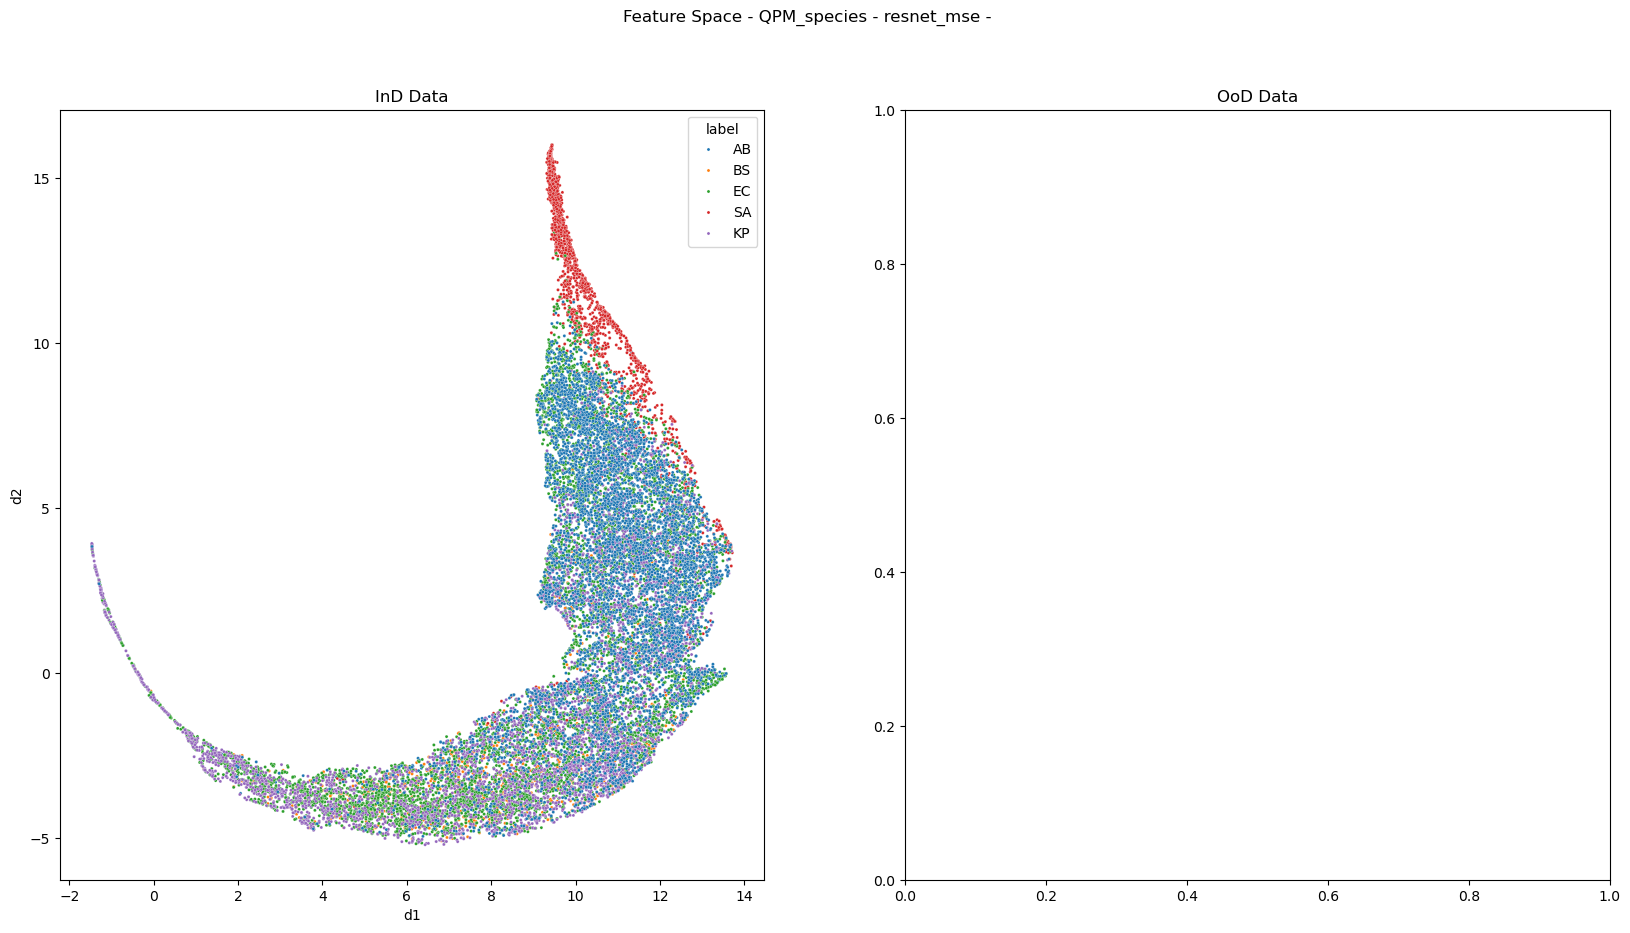

In [12]:
# plot feature space
df_emb2d = pd.DataFrame()
d1, d2 = ind_emb2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_emb2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

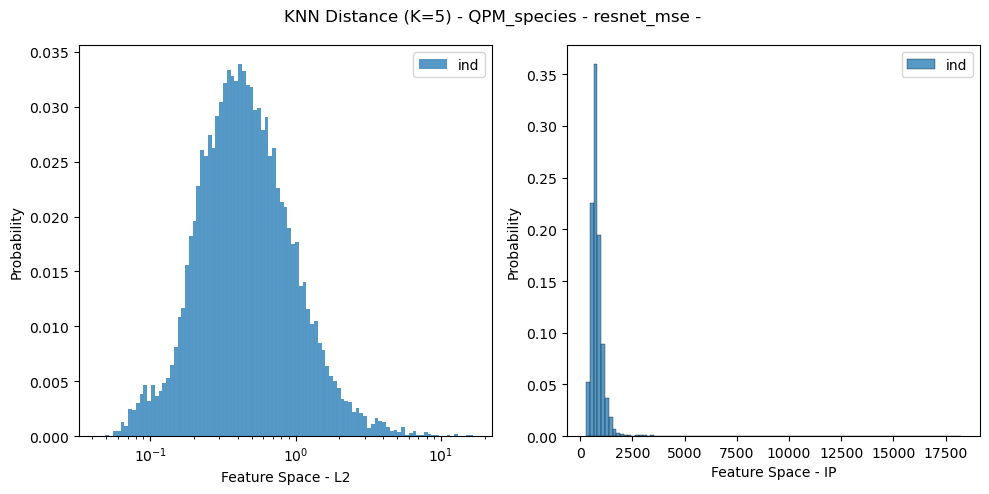

In [13]:
# plot knn distance from ind/ood to val data
def plot_knn_dists(index_fn, ax, trn_data, val_data, ind_data, ood_data=None, k=5, scale="linspace"):
    stats = {}
    index = index_fn(trn_data.shape[-1])
    index.add(trn_data)
    Dv = index.search(val_data, k)[0].mean(-1)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc, val_data=Dv.tolist(), ind_data=Di.tolist(), ood_data=Do.tolist()))
        
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()
    return stats

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
fig.suptitle(f"KNN Distance (K=5) - {dataset_name} - {model_name} - {ood_str}")
run_stats["knn_f_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[0], trn_emb, val_emb, ind_emb, ood_emb if ood_str else None, scale="logspace")
axs[0].set_xlabel("Feature Space - L2")
run_stats["knn_f_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[1], trn_emb, val_emb, ind_emb, ood_emb if ood_str else None, scale="linspace")
axs[1].set_xlabel("Feature Space - IP")
plt.tight_layout()
plt.show()

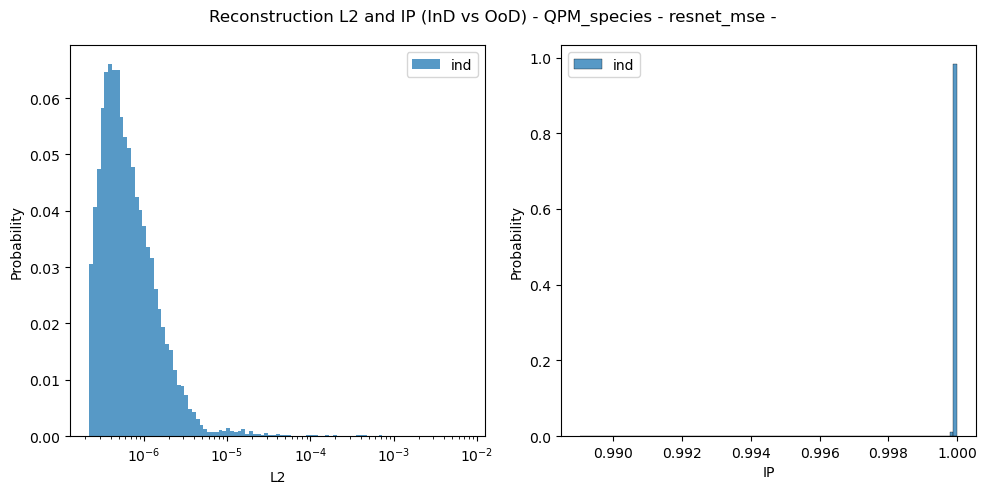

In [14]:
# plot reconstruction error of ind and ood data
def plot_rcn(val_rcn, ind_rcn, ood_rcn, ax, scale="linspace"):
    stats = {}
    D = ind_rcn
    if ood_str:
        D = np.concatenate([ind_rcn, ood_rcn], axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(ind_rcn, label="ind", stat="probability", bins=bins, ax=ax)
    if ood_str:
        sns.histplot(ood_rcn, label="ood", stat="probability", bins=bins, ax=ax)
        T = np.concatenate([[0]*ind_rcn.shape[0],[1]*ood_rcn.shape[0]], axis=0)
        Ci = np.histogram(ind_rcn, bins, density=True)[0]
        Co = np.histogram(ood_rcn, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(ood_rcn, ind_rcn)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        ax.set_title(f"KL={kld:.4f}, EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc, val_data=val_rcn.tolist(), ind_data=ind_rcn.tolist(), ood_data=ood_rcn.tolist()))
    if scale == "logspace":
        ax.set_xscale("log")
    ax.legend()
    return stats

flatten = lambda x: x.reshape((x.shape[0], -1))
unit = lambda x: x / (np.linalg.norm(x, axis=-1, keepdims=True) + 1e-7)

# training data
_val_inp, _val_rcn = flatten(val_inp), flatten(val_rcn)
_val_inp_unit, _val_rcn_unit = unit(_val_inp), unit(_val_rcn)
# metrics
val_rcn_l2 = ((_val_inp - _val_rcn) ** 2).mean(-1)
val_rcn_ip = (_val_inp_unit * _val_rcn_unit).sum(-1)

# ind test data
_ind_inp, _ind_rcn = flatten(ind_inp), flatten(ind_rcn)
_ind_inp_unit, _ind_rcn_unit = unit(_ind_inp), unit(_ind_rcn)
# metrics
ind_rcn_l2 = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_rcn_ip = (_ind_inp_unit * _ind_rcn_unit).sum(-1)

if ood_str:
    # ood test data
    _ood_inp, _ood_rcn = flatten(ood_inp), flatten(ood_rcn)
    _ood_inp_unit, _ood_rcn_unit = unit(_ood_inp), unit(_ood_rcn)
    # metrics
    ood_rcn_l2 = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_rcn_ip = (_ood_inp_unit * _ood_rcn_unit).sum(-1)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
run_stats["rcn_l2"] = plot_rcn(val_rcn_l2, ind_rcn_l2, ood_rcn_l2 if ood_str else None, ax1, scale="logspace")
ax1.set_xlabel("L2")
run_stats["rcn_ip"] = plot_rcn(val_rcn_ip, ind_rcn_ip, ood_rcn_ip if ood_str else None, ax2, scale="linspace")
ax2.set_xlabel("IP")
plt.suptitle(f"Reconstruction L2 and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

In [15]:
run_stats.update(dict(dataset_name=dataset_name, model_name=model_name, ood=ood))
import gzip
import pickle
with gzip.open(f"{save_name}_stats.gz", "wb") as f:
    pickle.dump(run_stats, f)